In [23]:
compounds_str = """
part1-CO2_50-FeO_50:
CO2: 50%
FeO: 50%

part2-CO_20-Fe_50-AgO_20-AlO_10:
CO: 20%
Fe: 50%
AgO: 20%
AlO: 10%

part3-HCO2_15-FeO2_60-Ag_25:
HCO2: 15%
FeO2: 60%
Ag: 25%

part4-HCO2_20-FeO2_60-Ag_20:
HCO2: 20%
FeO2: 60%
Ag: 20%
"""
import torch
import datetime
from typing import List, Tuple, Literal
import importlib
import matplotlib.pyplot as plt
from IPython import display

import mark_essential_oils
from mark_essential_oils import Config, gen_examples, train
import notebook

importlib.reload(mark_essential_oils)
importlib.reload(notebook)

# import seaborn as sns
# import pandas
# sns.set_theme()


<module 'notebook' from '/home/tim/devel/nnfs/notebook.py'>

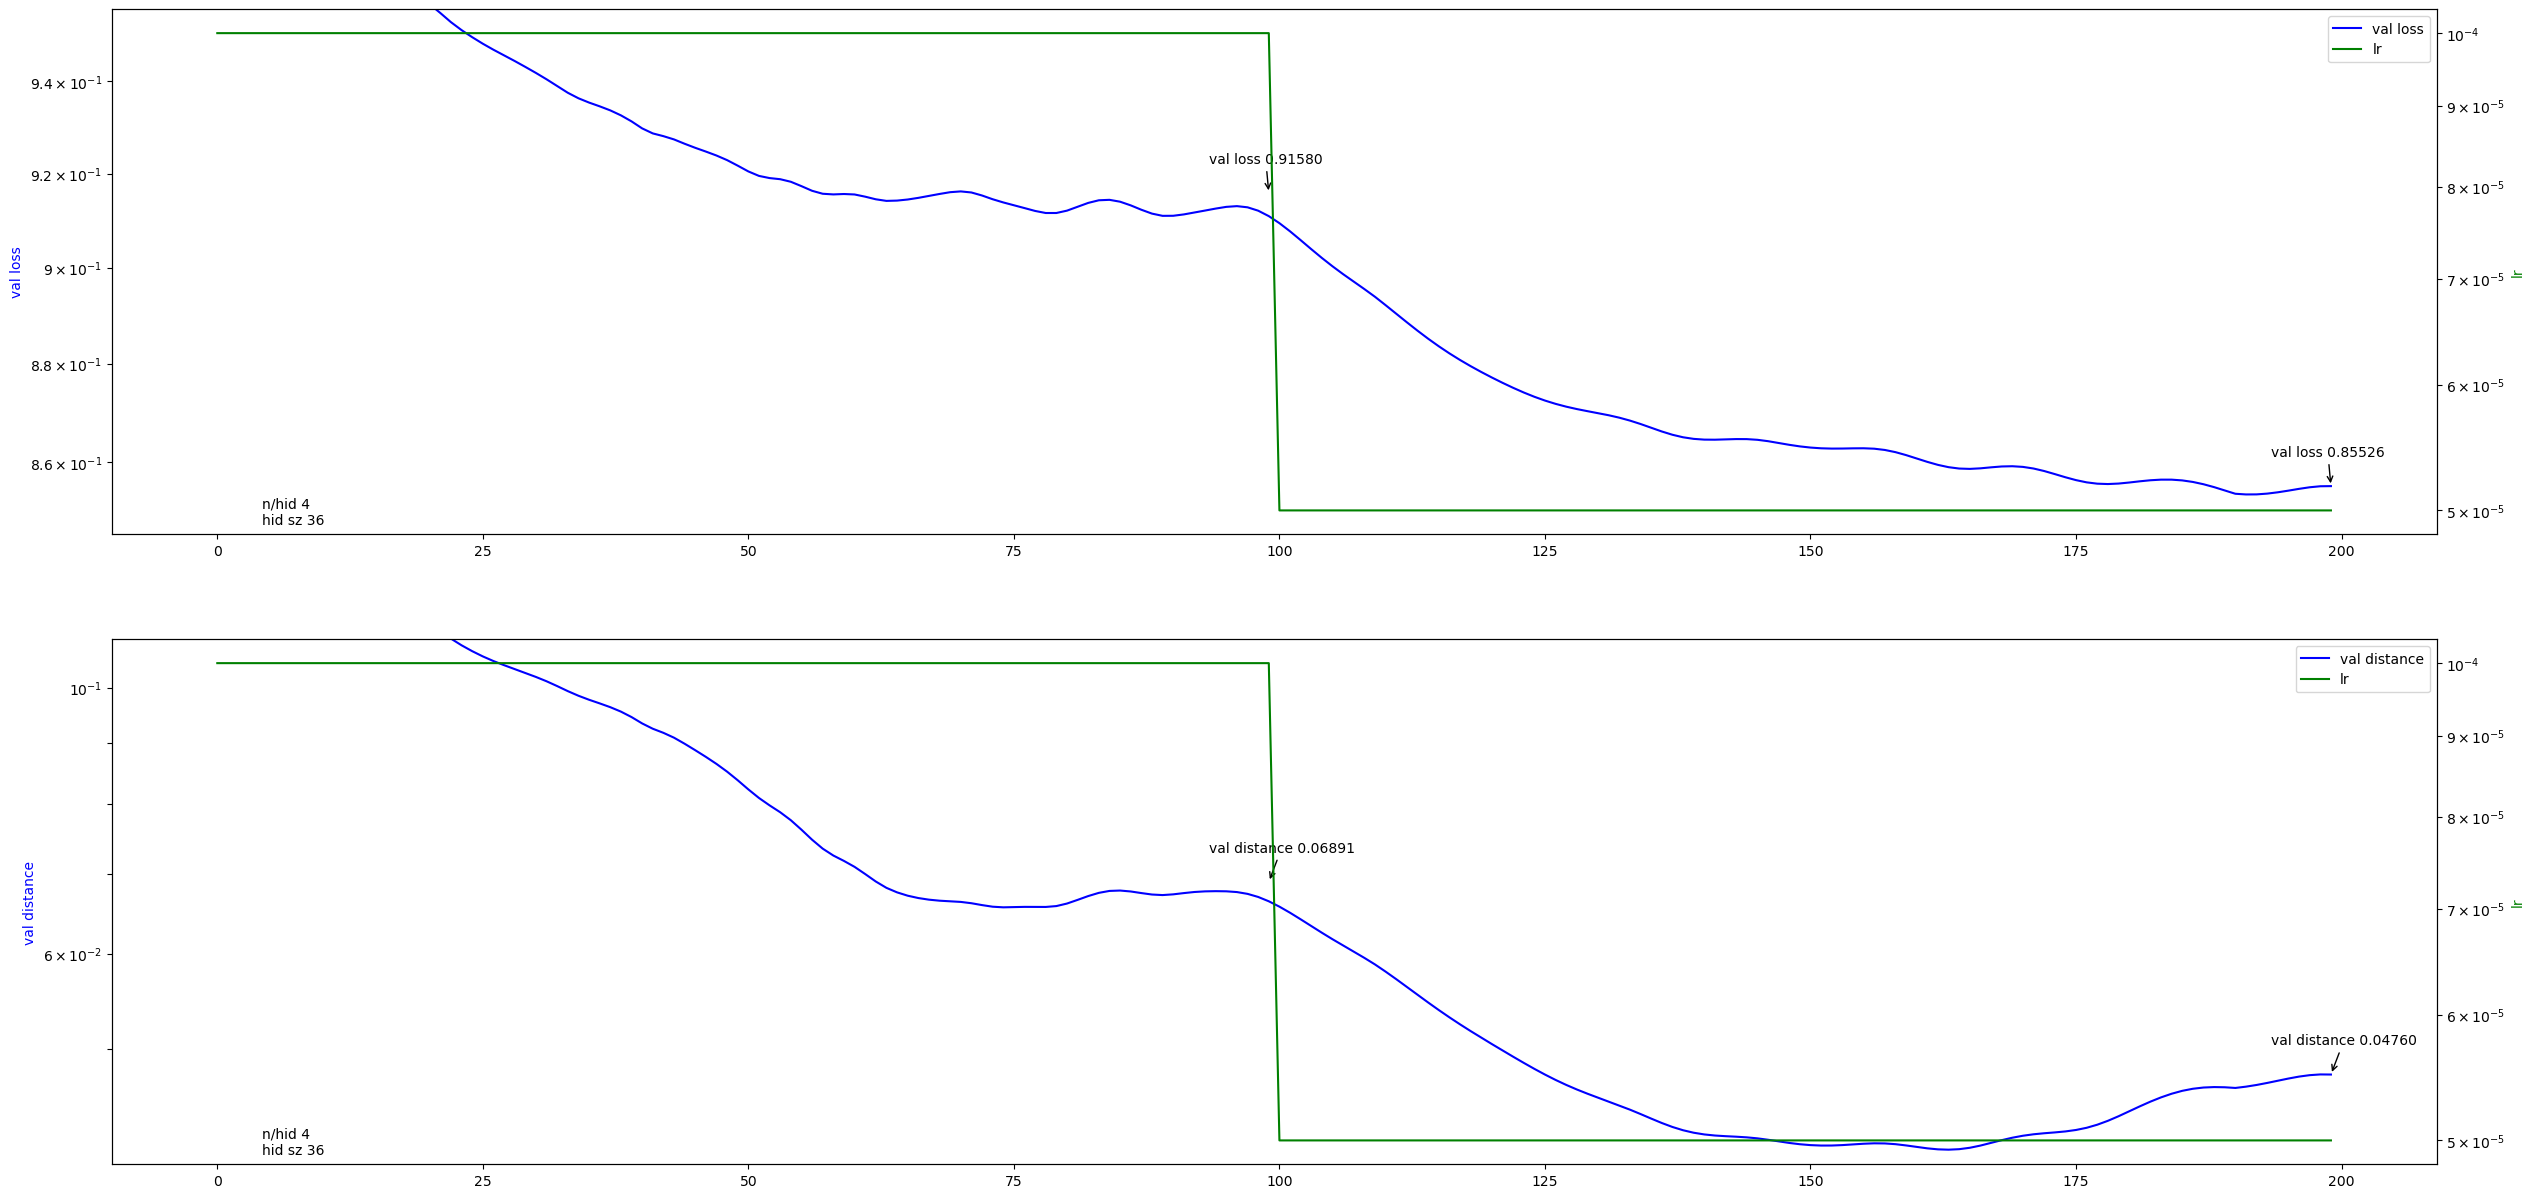

KeyboardInterrupt: 

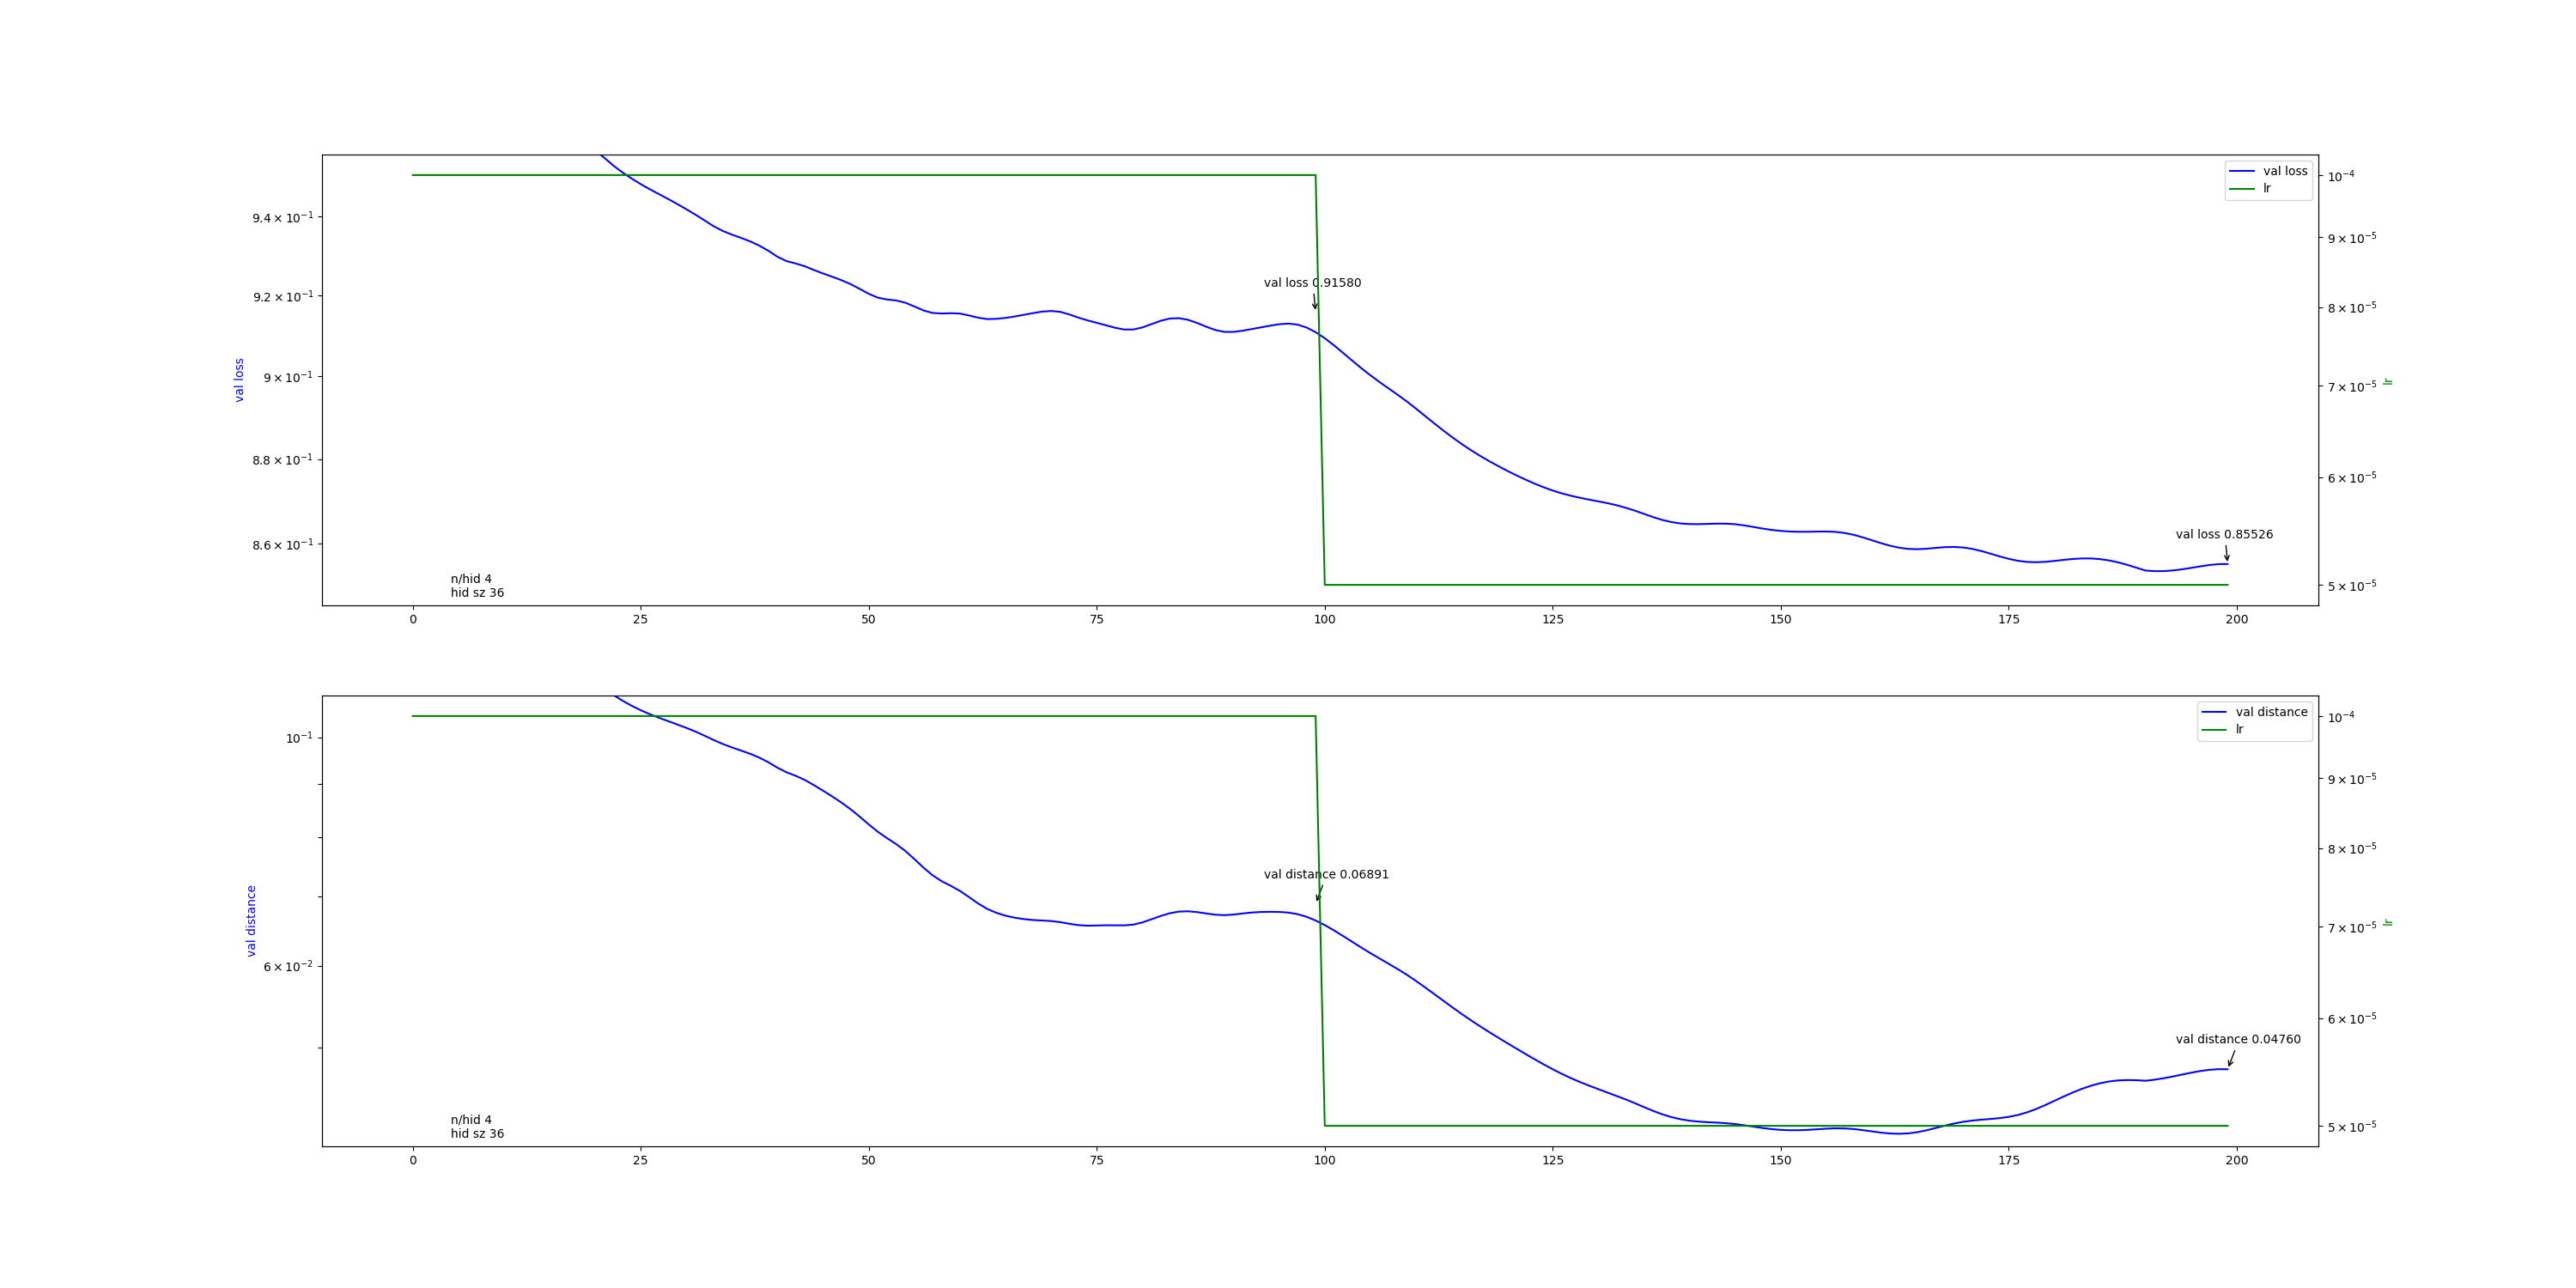

In [24]:
%matplotlib widget

cfg = Config(compounds_str)
cfg.setup(num_hidden=3, hidden_size=len(cfg.all_mol_names), lr=1e-4)

colors = ["blue", "green"]
num_mol = len(cfg.all_mol_names)
hp_num_batches = 10
hp_batch_size = 1000
hp_learning_rates = {1e-4: 1000, 5e-5: 1000, 3e-5: 5000, 1e-5: 5000, 3e-6: 5000, 2e-6: 5000, 1e-6: 5000}
hp_num_hidden = [4, 6, 8, 10]
# hp_hidden_size = [num_mol * 6, num_mol * 8, num_mol * 10]
# hp_hidden_size = [num_mol * 6]
hp_hidden_size = [i * num_mol for i in range(4, 12, 2)]

# TODO - only for fast debugging
# hp_learning_rates = {k: v//100 for k, v in hp_learning_rates.items()}
# hp_learning_rates = {k: v//10 for k, v in hp_learning_rates.items()}

data_train = gen_examples(cfg, hp_num_batches, hp_batch_size)
data_val = gen_examples(cfg, hp_num_batches, hp_batch_size)

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
base_filename = ["outputs", "mark_essential_oils2", "results-" + timestr]
base_filename = "/".join(base_filename)

total_configs = len(hp_num_hidden) * len(hp_hidden_size)
total_epochs = sum(hp_learning_rates.values())

train_loss_hist = torch.zeros((total_epochs * total_configs, ))
val_loss_hist = torch.zeros_like(train_loss_hist)
val_dist_hist = torch.zeros_like(train_loss_hist)
lr_hist = torch.ones_like(train_loss_hist)

all_figs = list() # of matplotlib.figure.Figure
config_idx = 0
for num_hidden in hp_num_hidden:
    for hidden_size in hp_hidden_size:
        cfg.setup(num_hidden=num_hidden, hidden_size=hidden_size, lr=1e-4)

        print()
        print(f"num_hidden {num_hidden}, hidden_size {hidden_size}")

        epochs_at_cfg = 0
        cfg_epochs = sum(hp_learning_rates.values())
        fig = plt.figure(config_idx, (30, 15))
        all_figs.append(fig)
        plot_val_loss = notebook.Plot(cfg_epochs, ["val loss", "lr"], colors, fig, nrows=2, idx=1)
        plot_val_dists = notebook.Plot(cfg_epochs, ["val distance", "lr"], colors, fig, nrows=2, idx=2)
        config_idx += 2
        
        annotext = f"n/hid {num_hidden}\nhid sz {hidden_size}"
        plot_val_loss.add_annotation(0, (0, 0), annotext, "title")
        plot_val_dists.add_annotation(0, (0, 0), annotext, "title")

        for lridx, (lr, epochs) in enumerate(hp_learning_rates.items()):
            torch_filename = f"{base_filename}-lr_{lr}-num_hidden_{num_hidden}-hidden_size_{hidden_size}-start.torch"
            torch.save(cfg.net, torch_filename)
            print(f"saved {torch_filename}")

            lr_tensor = torch.ones((epochs,)) * lr

            print(f"lr = {lr} (num_hidden {num_hidden}, hidden_size {hidden_size})")
            cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=lr)

            tlosses, vlosses, vdists = train(cfg, epochs, data_train, data_val)
            plot_val_loss.add_data([vlosses, lr_tensor])
            plot_val_dists.add_data([vdists, lr_tensor])

            smooth_steps = 20
            chop_top_quantile = 0.9
            plot_val_loss.render(chop_top_quantile, smooth_steps, True)
            plot_val_dists.render(chop_top_quantile, smooth_steps, True)

            display.clear_output(True)
            for f in all_figs:
                display.display(f)
                # plt.show(f)

            epochs_at_cfg += epochs

            torch_filename = f"{base_filename}-lr_{lr}-num_hidden_{num_hidden}-hidden_size_{hidden_size}-epoch{epochs_at_cfg:05}.torch"
            torch.save(cfg.net, torch_filename)
            img_filename = f"{base_filename}.png"
            fig.savefig(img_filename)
            print(f"saved {img_filename} & {torch_filename}")


In [ ]:
import matplotlib
tensors = [m.weight.grad for m in cfg.net.modules() if isinstance(m, torch.nn.Linear)]
# tensors = [t.abs() > 0.001 for t in tensors]
tensors = [t.abs() < .01 for t in tensors]
# tensors = [torch.clamp(t, min=-1.0+1e-7, max=1.0-1e-7) for t in tensors]
# tensors = [m.weight for m in cfg.net.modules() if isinstance(m, torch.nn.Linear)]
count_all_rows = max([t.shape[0] for t in tensors])
count_all_cols = sum([t.shape[1] for t in tensors])

all_tensors = torch.zeros((count_all_rows, count_all_cols))
running_col = 0
for t in tensors:
    trows, tcols = t.shape
    print(f"trows {trows}, tcols {tcols}")
    print(f"[:{trows}, {running_col}:{running_col+tcols}] = {t.shape}")
    all_tensors[:trows, running_col:running_col+tcols] = t
    running_col += tcols

plt.matshow(all_tensors.detach().cpu(), cmap=matplotlib.cm.gray, vmin=-1, vmax=1)
all_tensors
